# Kepler's First Law:

*The orbit of a planet is an ellpise with the Sun at one of the two foci*

Although the Sun contains over 99% of the Solar System's mass, the remaining 1% could influence the barycentre of the sun, thus making Kepler's law slightly wrong. The question is is going be answered here is whether movements in the Solar System Barycentre WRT Sun's centre are significant.

## Using SPICE

We can load individual SPICE kernels to complete various miscellaneous calculations. However, given the magnitude of space, it is possible to use kernel meta files that themselves contain relative or absolute paths to the required kernels.

In [1]:
import datetime
import spiceypy
import numpy as np

# Loading SPICE kernels with meta file
spiceypy.furnsh('/home/einhard/Documents/projects/zData/spicepy/meta/keplerFirstLaw.txt')

In [2]:
# Computing the SSB WRT the centre of the Sun for a specific time interval

# Setting initial time in UTC
# Here we set midnight UTC on 2000-01-01, and then we'll add up days as necessary
INIT_TIME_UTC = datetime.datetime(year=2000,
                                  month=1,
                                  day=1,
                                  hour=0,
                                  minute=0,
                                  second=0
)

# Adding a number of days for time interval
DELTA_DAYS  = 10000
END_TIME_UTC = INIT_TIME_UTC + datetime.timedelta(days=DELTA_DAYS)

# Converting datetime objects into strings
INIT_TIME_UTC_STR = INIT_TIME_UTC.strftime('%Y-%m-%dT%H:%M:%S')
END_TIME_UTC_STR = END_TIME_UTC.strftime('%Y-%m-%dT%H:%M:%S')

print('Init time in UTC: %s' % INIT_TIME_UTC)
print('End time in UTC: %s' % END_TIME_UTC)

# Convert times to Ephemeris Time using utc2et
INIT_TIME_ET = spiceypy.utc2et(INIT_TIME_UTC_STR)
END_TIME_ET = spiceypy.utc2et(END_TIME_UTC_STR)

Init time in UTC: 2000-01-01 00:00:00
End time in UTC: 2027-05-19 00:00:00


### Adding leap seconds

A day has 24 hours, a year has 365 days, and every 4 years we add another day. This leap day, over the 10,000 day period we specified adds up to 864,000,000 seconds (10k days times 86.4k seconds for each day). 

The precision here is important - if we subtract the end ET from the initial ET, we'll see that there's a difference of about 5 seconds:

In [3]:
print(END_TIME_ET - INIT_TIME_ET - 864000000)

5.00128448009491


In [4]:
# Accounting for leap years
# A day has 86400 seconds (24 hrs * 60 min * 60 sec)

# We would expect our time interval to be 86.4k seconds, given the 10k range.
# However, we can see that a few seconds are added to the calculation
print('Covered time interval in seconds: %s\n' % (END_TIME_ET - INIT_TIME_ET))

# To account for this, we can create a numpy array that covers the time interval in delta=1 day step
TIME_INTERVAL_ET = np.linspace(INIT_TIME_ET, END_TIME_ET, DELTA_DAYS)

Covered time interval in seconds: 864000005.0012845



## Computing the Solar System Barycentre

With the time interval established and leap seconds accounted for, we can calculate the SSB's position in x, y, z direction WRT the Sun's centre. To do this, we have to use SPICE's [spkgps](https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/C/cspice/spkgps_c.html). This function takes the following inputs:

* **targ**: The NAIF ID code of the SSB (0). Other NAIF ID's are available [here](https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/C/req/naif_ids.html)
* **et**: The Ephemeris time
* **ref**: The reference frame (ECLIPJ2000 in this case; we use Earth's ecliptic as ref)
* **obs**: The NAIF ID of the Sun (10)


*Note: spkgeo is used to find position and velocity, spkgps is used to find geometric position*

In [5]:
# Computing SSB WRT the Sun

# Creating empty list to store all x,y,z components for each time step
SSB_WRT_SUN_POSITION = []

# Using a for loop to compute position of SSB WRT the Sun for each time step
for TIME_INTERVAL_ET_f in TIME_INTERVAL_ET:
    _position, _ = spiceypy.spkgps(targ=0,
                                   et=TIME_INTERVAL_ET_f,
                                   ref='ECLIPJ2000',
                                   obs=10)
    # Appending result to final list
    SSB_WRT_SUN_POSITION.append(_position)

# Converting list to Numpy array
SSB_WRT_SUN_POSITION = np.array(SSB_WRT_SUN_POSITION)

In [6]:
SSB_WRT_SUN_POSITION[0]

array([1068000.18910616,  417680.94186646,  -30844.65828755])

In [7]:
SSB_WRT_SUN_POSITION.shape

(10000, 3)

In [8]:
# Let's have a look at the first entry and ...
print('Position (components) of the Solar System Barycentre w.r.t the\n' \
      'centre of the Sun (at inital time): \n' \
      'X = %s km\n' \
      'Y = %s km\n' \
      'Z = %s km\n' % tuple(np.round(SSB_WRT_SUN_POSITION[0])))

# ... let's determine and print the corresponding distance using the numpy
# function linalg.norm()
print('Distance between the Solar System Barycentre w.r.t the\n' \
      'centre of the Sun (at initial time): \n' \
      'd = %s km\n' % round(np.linalg.norm(SSB_WRT_SUN_POSITION[0])))

Position (components) of the Solar System Barycentre w.r.t the
centre of the Sun (at inital time): 
X = 1068000.0 km
Y = 417681.0 km
Z = -30845.0 km

Distance between the Solar System Barycentre w.r.t the
centre of the Sun (at initial time): 
d = 1147185 km



From the above calculation we can see that the SSB WRT the Sun is over 1 million kilometers (around 3 times the distance between the Earth and the Moon). This, however, needs to be scaled in order to interpret correctly: we can use AU, 1 Light-year, etc.

In this tutorial, a custom scale is used, where we look at the radius of the Sun by extracting it from the appropriate SPICE kernel. To do this we can use the [bodvcd](https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/C/cspice/bodvcd_c.html) function, which takes in three parameters:

* **bodyid**: the NAIF ID of the body in question
* **item**: 'RADII' tells the function we need the radius of the *bodyid*
* **maxn**: The number of expected return parameters. The radius of an ellipsoid can be determined with the 3 values (x,y,z directions)

In [9]:
# The first value that is returned by bodvcd is the number of return values
# Additionally, since all radii values are the same, we simply use the first one
_, RADII_SUN = spiceypy.bodvcd(bodyid=10,
                               item='RADII',
                               maxn=3)
RADIUS_SUN = RADII_SUN[0]

# Scaling position values with Sun's radius
SSB_WRT_SUN_POSITION_SCALED = SSB_WRT_SUN_POSITION / RADIUS_SUN

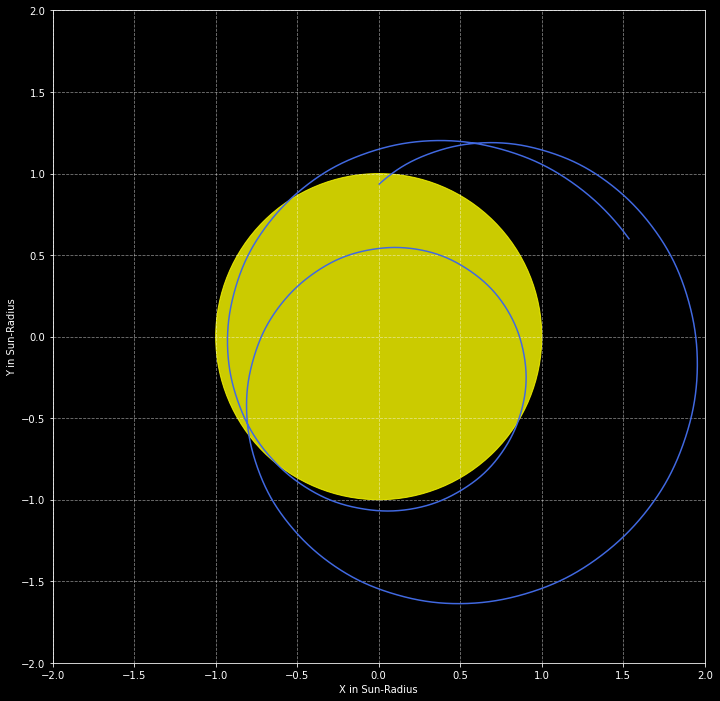

In [14]:
# We only plot the x, y components (the view on the ecliptic)
SSB_WRT_SUN_POSITION_SCALED_XY = SSB_WRT_SUN_POSITION_SCALED[:, 0:2]

# Once scaled, we can use matplotlib to plot the trajectory of SSB WRT the Sun
from matplotlib import pyplot as plt
plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(15,12))

# Creating a yellow circle that represents the Sun
SUN_CIRC = plt.Circle((0.0,0.0), 1.0, color='yellow', alpha=0.8)
ax.add_artist(SUN_CIRC)

# Plotting SSB movement
ax.plot(SSB_WRT_SUN_POSITION_SCALED_XY[:,0],
        SSB_WRT_SUN_POSITION_SCALED_XY[:,1],
        ls='solid', color='royalblue')

# Setting ratios, grid, and x, y limits
ax.set_aspect('equal')
ax.grid(True, linestyle='dashed', alpha=0.5)
ax.set_xlabel('X in Sun-Radius')
ax.set_xlim(-2,2)
ax.set_ylabel('Y in Sun-Radius')
ax.set_ylim(-2,2)

# Saving figure
plt.savefig('figures/SSB_WRT_SUN.png', dpi=300)

The blue line here represents the trajectory of the SSB. We can clearly see that it is not within the Sun at all times, even though the Sun has over 99% of the Solar System's mass.

In [15]:
# How many days is the SSB outside the Sun
# First we calculate the eucledian distance between SSB and the Sun
SSB_WRT_SUN_DISTANCE_SCALED = np.linalg.norm(SSB_WRT_SUN_POSITION_SCALED, axis=1)
print('Computation time: %s days\n' % DELTA_DAYS)

# Compute number of days outside the Sun
SSB_OUTSIDE_SUN_DELTA_DAYS = len(np.where(SSB_WRT_SUN_DISTANCE_SCALED > 1)[0])
print('Fraction of time where the SSB was outside the Sun: %s %%' % (100 * SSB_OUTSIDE_SUN_DELTA_DAYS / DELTA_DAYS))

Computation time: 10000 days

Fraction of time where the SSB was outside the Sun: 64.64 %
